Recommendation System is a subclass of information filtering system that seeks to predict the “rating” or “preference” a user would give to an item.Recommendation Systems are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags, and products in general.
The main aim of recommendation systems are to recommend relevant items to a user based on historical data.

# Contents

<a href='#part1'>1. Business Problem</a> \
<a href='#part2'>2. Preprocessing</a> \
<a href='#part3'>3. Exploratory Data Analysis on Train Data</a>\
<a href='#part4'>4. Creating USER-MOVIE sparse matrix from data frame</a>\
<a href='#part5'>5. Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</a>\
<a href='#part6'>6. Computing Similarity Matrices</a>\
<a href='#part7'>7. Transforming Data for training ML Models</a>\
<a href='#part8'>8. ML Models</a>
- <a href='#part81'>8.1 XGBOOST REGRESSOR</a>
- <a href='#part82'>8.2 Surprise BaselineOnly Model</a>
- <a href='#part83'>8.3 Surprise KNN-Baseline and KNBasic</a>
- <a href='#part83'>8.3.1 Surprise KNN-Baseline with User-User</a>
- <a href='#part85'>8.3.2 Surprise KNN-Baseline with Movie-Movie</a>
- <a href='#part86'>8.3.3 Surprise KNNBasic with User-User</a>
- <a href='#part87'>8.3.4 Surprise KNNBasic with Movie-Movie</a>
- <a href='#part88'>8.4 Matrix Factorization SVD</a>\

<a href='#part9'>9. Recommendations</a>\
<a href='#part10'>10. Ethical Issues</a>

<a id='part1'></a>
## 1.  BUSINESS PROBLEM

To understand the power of recommendation systems, it is easiest to focus on Netflix, whose state of the art recommendation system keeps us in front of our TVs for hours. However, recommenders are extremely diverse, playing a role in cross-selling products, identifying employee candidates who have similar skill sets, and finding customers who will respond to promotional messaging. And these examples only just scratch the surface of how recommendations systems can be used.

Although recommenders can be very complex, there are two simple approaches that act as a good starting point.

**Content based filtering:** uses item features to recommend similar items to the ones that a user has previously liked or interacted with. Pandora‘s music genome project identifies musical attributes for each song and uses that information to find similar songs and make recommendations.

**Collaborative filtering:** identifies items that a user will like based on how similar users rated each item. Netflix identifies shows and movies users will enjoy by determining which content similar users watched.



Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.

Credits: https://www.netflixprize.com/rules.html


### Problem Statement


Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

### References

1. https://medium.com/@narendra09b/recommendation-systems-6cedb4cb7cec
2. https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
3. https://laptrinhx.com/a-simple-approach-to-building-a-recommendation-system-452318104/

### Machine Learning Objective and Constraints


 - To Minimize RMSE.
 - Try to provide some Interpretability.

<a id='part2'></a>
## 2. Preprocessing

### Importing Libraries

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix, find
import itertools
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline, KNNBasic
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
starttime = datetime.now()

In [3]:
# Reading the csv file

Final_Data=pd.read_csv("ratings.csv",parse_dates=True).drop(columns=["TIME"])

In [4]:
Final_Data.head()

,CustID,MovieID,Ratings,Date
0,4,1,4.0,4/20/2005
1,10,1,5.0,1/30/2000
2,14,1,4.5,9/14/2015
3,15,1,4.0,6/13/2013
4,22,1,4.0,3/23/2009


### Checking for NaN

In [5]:
# Dropping Nan and null values
Final_Data=Final_Data.dropna()
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

Number of NaN values = CustID     0
MovieID    0
Ratings    0
Date       0
dtype: int64


### Changing Data Type

In [6]:
# Changing Data type to int for ordinal features
Final_Data["Ratings"]=Final_Data["Ratings"].astype(int)
Final_Data["MovieID"]=Final_Data["MovieID"].astype(int)
Final_Data["CustID"]=Final_Data["CustID"].astype(int)


Final_Data['Date']= pd.to_datetime(Final_Data['Date'])

### Removing Duplicates

In [7]:
# removing any duplicate entries of data
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])

Final_Data=Final_Data.drop_duplicates(subset=["MovieID","CustID", "Ratings"], keep='last')
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


### Basic Statistics on Whole data

In [8]:
# Getting the unique ratings and users data from the csv

print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total Data:
Total number of movie ratings = 1048546
Number of unique users = 10532
Number of unique movies = 22147


### Spliting data into Train and Test(80:20) 

After sorting the date in increasing order , we are going to split first 80% of data in Train and bottom 20% of data in Test .

In [9]:
Final_Data.sort_values(by=["Date","MovieID"],inplace=True)

In [10]:
Train_Data=Final_Data.iloc[:int(Final_Data.shape[0]*0.80)]
Test_Data=Final_Data.iloc[int(Final_Data.shape[0]*0.80):]

### Basic Statistics in Train data

In [11]:
Train_Data.head()

,CustID,MovieID,Ratings,Date
12025,5358,19,1,1996-01-30
67362,10031,219,5,1996-03-02
74166,4769,248,3,1996-03-02
77744,4769,256,4,1996-03-02
113487,4769,351,4,1996-03-02


In [12]:
Train_Data = Train_Data[Train_Data["Ratings"]!=0]

In [13]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))


Total Train Data:
Total number of movie ratings in train data = 826031
Number of unique users in train data = 9068
Number of unique movies in train data = 14963
Highest value of a User ID = 10531
Highest value of a Movie ID = 19198


### Basic Statistics in Test data

In [14]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 209710
Number of unique users in Test data = 1722
Number of unique movies in Test data = 16923
Highest value of a User ID = 10532
Highest value of a Movie ID = 22147


<a id='part3'></a>
## 3. Exploratory Data Analysis on Train Data

In [15]:
def changingLabels(number):
    return str(number/10**3) + "K"

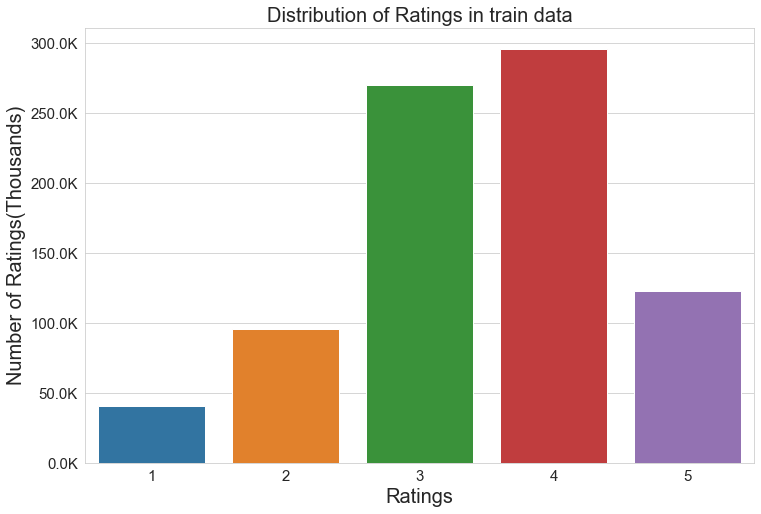

In [16]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Ratings", data=Train_Data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Thousands)", fontsize = 20)
plt.show()

# Inference -  Ratings above 3 are more popular than low rating

In [17]:
Train_Data["DayOfWeek"] = Train_Data.Date.dt.weekday

In [18]:
Train_Data.head()

,CustID,MovieID,Ratings,Date,DayOfWeek
12025,5358,19,1,1996-01-30,1
67362,10031,219,5,1996-03-02,5
74166,4769,248,3,1996-03-02,5
77744,4769,256,4,1996-03-02,5
113487,4769,351,4,1996-03-02,5


In [19]:
Train_Data.dtypes

CustID                int32
MovieID               int32
Ratings               int32
Date         datetime64[ns]
DayOfWeek             int64
dtype: object

### Analysis of Ratings given by user

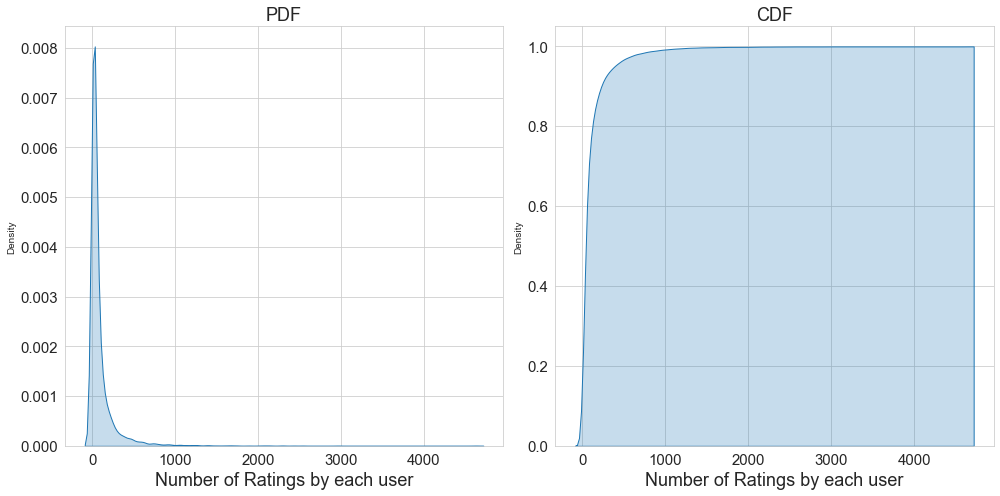

In [20]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by each user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by each user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

# Inference - Maximum users are providing around 100 Ratings
# 99% of Users are giving less than 1000 ratings

In [21]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    9068.000000
mean       91.092964
std       185.478367
min         1.000000
25%        15.000000
50%        29.000000
75%        87.000000
max      4627.000000
Name: Ratings, dtype: float64

In [22]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))
# step of 0.01 from 0 to 1
#quantiles

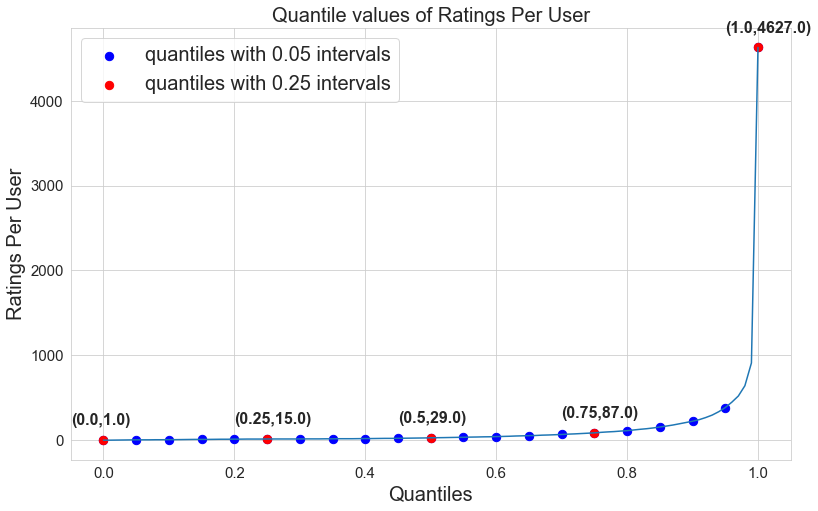

In [23]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)

### Analysis of Movie Ratings on Day of Week

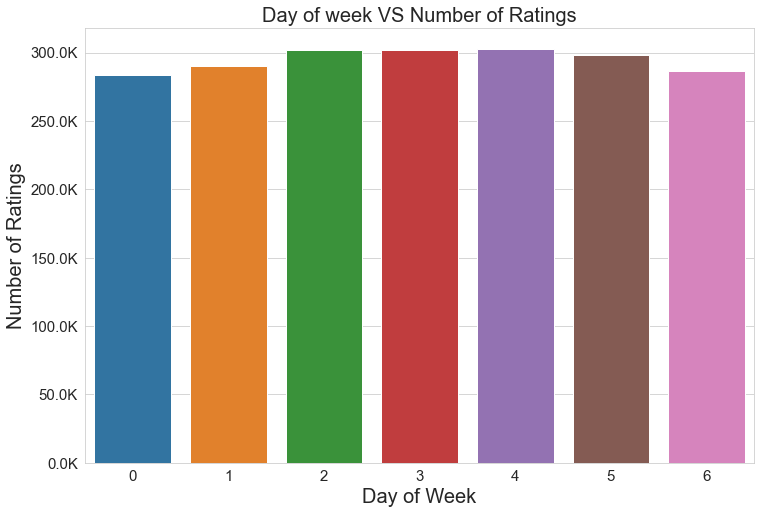

In [24]:

fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

# Inference - Day of Week is not providing any significant information about users 

<a id='part4'></a>
## 4. Creating USER-MOVIE sparse matrix from data frame

In [25]:
# csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k]

# csr matrix use less memory and space compared to numpy arrays

startTime = datetime.now()
print("Creating USER_MOVIE sparse matrix for train Data")
if os.path.isfile("../Data/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("../Data/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_MOVIE sparse matrix for train Data
We are creating sparse data
Creation done. Shape of sparse matrix = (10532, 19199)
Saving it into disk for furthur usage.
Done

0:00:00.600194


In [26]:
startTime = datetime.now()
print("Creating USER_MOVIE sparse matrix for test Data")
if os.path.isfile("../Data/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("../Data/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_MOVIE sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (10533, 22148)
Saving it into disk for furthur usage.
Done

0:00:00.154067


In [28]:
#If you can see above that the shape of both train and test sparse matrices are different, furthermore, how come this shape of sparse
#matrix has arrived:
#Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
#Now the user whose user ID is highest is present in  test data and not in train data. Similarly, the movie whose movie ID is
#highest is present in test data and not in train data. Hence, shape of both train and test sparse matrices are different.

In [29]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.591486054065% 


<a id='part5'></a>
## 5. Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [30]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    
    #this will give an array of sum of all the ratings of user if axis = 1 else sum of all the ratings of movie 
    #here A1 is flatenning the array
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  
    
    #Count if number of rows with non zero rating
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  
    
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

# this method returns a dictionary- if ax =1 then {movie: average rating of movie} else {user: average rating of user}

In [31]:
# example of the output of above method- for each userID
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
dict(itertools.islice(AvgRatingUser.items(), 6))

{1: 2.9375,
 2: 3.4,
 3: 3.5454545454545454,
 4: 3.4153166421207657,
 5: 4.097222222222222,
 6: 3.5476190476190474}

In [32]:
# example of the output of above method- for each MovieID
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
dict(itertools.islice(AvgRatingMovie.items(), 6))

{1: 3.8097582811101165,
 2: 3.129370629370629,
 3: 3.1742671009771986,
 4: 2.9285714285714284,
 5: 3.0538599640933572,
 6: 3.7586206896551726}

### Average Rating Per User

In [33]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
print("Average rating of user 25 = {}".format(AvgRatingUser[25]))

Average rating of user 25 = 3.75


### Average Rating Per Movie

In [34]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))


Average rating of movie 4500 = 2.5714285714285716


### Global Average Rating

In [35]:
# count_nonzero method counts the actual number of non-zero entries in data

Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.44190593331243


### PDF and CDF of Average Ratings of Users and Movies¶


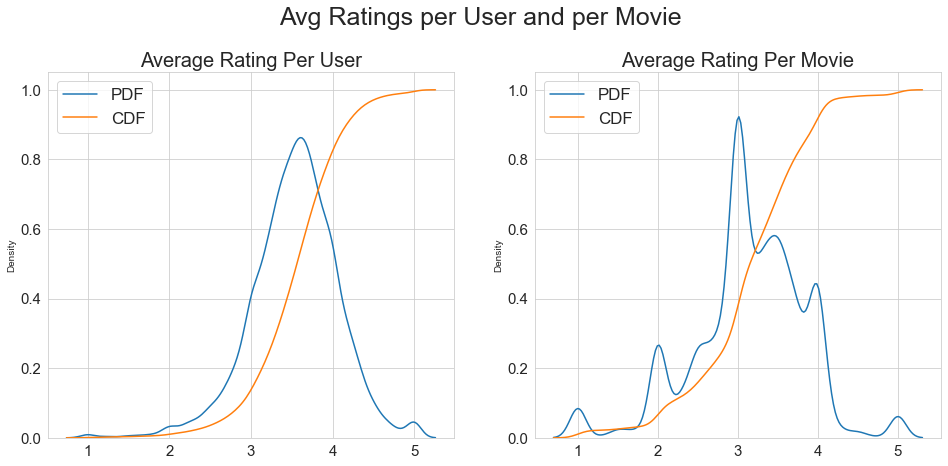

In [36]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=25)

# We obtained the average rating per user/per movie from the Sparse Matrix

user_average = [rats for rats in AvgRatingUser.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in AvgRatingMovie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

# inference - 80% of users have less than 4 as their average rating across all the movies they have rated


### Cold Start Problem


With recommendation engines, the “cold start” simply means that the circumstances are not yet optimal for the engine to provide the best possible results. Specifically, it concerns the issue that the system cannot draw any inferences for users or items about which it has not yet gathered sufficient information.

#### Cold Start Problem with Users


In [37]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".\
      format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 10532
Number of Users in train data= 9068
Number of Users not present in train data = 1464(14.0%)


#### Cold Start Problem with Movies


In [38]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".\
      format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 22147
Number of Movies in train data= 14963
Number of Movies not present in train data = 7184(32.0%)


<a id='part6'></a>
## 6. Computing Similarity Matrices


In [39]:
arr=np.array([[1,0,1],[1,1,1],[1,1,1],[0,0,0],[0,0,0]])

arr.shape

cosine_similarity(arr.T)

cosine_similarity(arr)

In [43]:
# This works by computing similarity as the normalized dot product 

#### Computing User-User Similarity Matrix 


In [44]:
u_u_similarity = cosine_similarity(TrainUISparseData, dense_output = False)
print("Done")
print("Dimension of Matrix = {}".format(u_u_similarity.shape))


Done
Dimension of Matrix = (10532, 10532)


#### Computing Movie-Movie Similarity Matrix


In [45]:
m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
print("Done")
print("Dimension of Matrix = {}".format(m_m_similarity.shape))


Done
Dimension of Matrix = (19199, 19199)


<a id='part7'></a>
## 7. Methods of Transforming data for training Machine Learning Models


We have used sample of our whole data as we could not process the whole data in laptop or in Amazon Sagemaker, So for the purpose training the model, we have used only a part of whole data. Get sample sparse matrix gives a sample of the data

In [47]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    # sparse.find returns tuple(I,J,V) contain the row indices, column indices, and values of the nonzero matrix entries
    users, movies, ratings = sparse.find(sparseMatrix)
    
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    
    #print (len(uniq_users))
    np.random.seed(20)   #this will give same random number everytime, without replacement
    
    userS = np.random.choice(uniq_users, n_users, replace = False)
    #print(uniq_users)
    #print (userS)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    #print (uniq_movies)
    #print (movieS)
    
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))

    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    #print(sparse_sample.toarray())
    return (sparse_sample)

In [48]:
# EXAMPLE

A = csr_matrix([[7.0, 0, 0],[0, 0, 0],[0, 4, 5],[1, 0, 5]])
print (find(A))
print ("\n")
print (get_sample_sparse_matrix(A, 2, 1))

(array([0, 3, 2, 2, 3], dtype=int32), array([0, 0, 1, 2, 2], dtype=int32), array([7., 1., 4., 5., 5.]))


Shape of Sparse Sampled Matrix = (3, 2)
  (2, 1)	4.0


In [49]:
# EXAMPLE

element = 2*np.arange(4).reshape((2, 2))
print (element)
test_elements = [1, 2, 4, 6]

mask = np.isin(element, test_elements)
print(mask)

print(element[mask])

[[0 2]
 [4 6]]
[[False  True]
 [ True  True]]
[2 4 6]


#### Creating Sample Sparse Matrix for Train and Test Data


In [50]:
TrainUISparseData.shape

(10532, 19199)

In [51]:
TestUISparseData.shape

(10533, 22148)

In [52]:
train_sample_sparse = get_sample_sparse_matrix(sparse.csr_matrix(TrainUISparseData[1:12000,1000:9000].todense()), 2000, 5001)
test_sample_sparse = get_sample_sparse_matrix(sparse.csr_matrix(TestUISparseData[1:1000,1000:10000].todense()), 100, 400)

Shape of Sparse Sampled Matrix = (10529, 7998)
Shape of Sparse Sampled Matrix = (989, 8979)


#### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)


In [53]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.46


In [54]:
# getAverageRatings method returns a dictionary of Users/Movies based on the arguments

globalAvgMovies = getAverageRatings(train_sample_sparse, False)
print("Average movie rating for movie 3 is {}".format(globalAvgMovies[284]))

Average movie rating for movie 3 is 3.9166666666666665


In [55]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Average user rating for user 67 is {}".format(globalAvgUsers[67]))

Average user rating for user 67 is 2.5789473684210527


In [56]:
print ("Shape of Sampled train matrix is : {}".format(train_sample_sparse.shape))
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print ("\n")
print ("Shape of Sampled test matrix is : {}".format(test_sample_sparse.shape))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

Shape of Sampled train matrix is : (10529, 7998)
No of ratings in Our Sampled train matrix is : 87428


Shape of Sampled test matrix is : (989, 8979)
No of ratings in Our Sampled test matrix is : 935


#### Featurizing Train Data


In [57]:
# Regression Analysis, we need to do featurising

sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

total_list=[]
for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
    row = list()
    row.append(user)  #appending user ID
    row.append(movie) #appending movie ID
    row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
    
    # finding cosine similarity of each user in the matrix
    similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
    
    # finding indices of top similar users except the user
    similar_users_indices = np.argsort(-similar_users)[1:]
    similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
    
    # if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
    #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
    top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
    top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))    
    row.extend(top_similar_user_ratings)

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
    similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
    similar_movies_indices = np.argsort(-similar_movies)[1:]
    similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
    top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
    top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
    #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
    #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
    row.extend(top_similar_movie_ratings)

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
    row.append(globalAvgUsers[user])
    row.append(globalAvgMovies[movie])
    row.append(rating)

    total_list.append(row)
    
    

In [58]:
Train_Reg=pd.DataFrame(total_list,columns = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])

#### Featurizing Test Data


In [61]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

total_list=[]
for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
    row=list()

    row.append(user)  #appending user ID
    row.append(movie) #appending movie ID
    row.append(round(test_sample_sparse.sum()/test_sample_sparse.count_nonzero(),2)) #appending global average rating
    #print (len(row))
    try:
        similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
        similar_users_indices = np.argsort(-similar_users)[1:]
        similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
        top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
        top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
        #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" 
        #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
        row.extend(top_similar_user_ratings)
        
    #########Cold Start Problem, for a new user #########    
    except(IndexError, KeyError):
        global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
        row.extend(global_average_train_rating)
    except:
        raise

#-----------------------------Ratings given by "user" to top 5 similar movies with "movie"-----------------------#
    try:
        similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
        #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
        #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
        row.extend(top_similar_movie_ratings)
        
    #########Cold Start Problem, for  a new movie#########    
    except(IndexError, KeyError):
        global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
        row.extend(global_average_train_rating)
        
    except:
        raise

#-----------------------------Appending "user" average, "movie" average & rating of "user""movie"----------------#
    try:        
        row.append(globalAvgUsers[user])
    except (KeyError):
        global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
        row.append(global_average_train_rating)
    except:
        raise

    try:
        row.append(globalAvgMovies[movie])
    except(KeyError):
        global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
        row.append(global_average_train_rating)
    except:
        raise

    row.append(rating)
    total_list.append(row)
    

In [62]:
Test_Reg=pd.DataFrame(total_list,columns = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])

In [65]:
Train_Reg.to_csv("Train_reg.csv")
Test_Reg.to_csv("Test_Reg.csv")

In [67]:
Train_Reg=pd.read_csv("Train_Reg.csv")
Train_Reg=Train_Reg.set_index(Train_Reg.columns[0])

Test_Reg=pd.read_csv("Test_Reg.csv")
Test_Reg=Test_Reg.set_index(Test_Reg.columns[0])


In [68]:
print(Train_Reg.shape)
print(Test_Reg.shape)

(87428, 16)
(935, 16)


**User_ID:** ID of a this User

**Movie_ID:** ID of a this Movie

**Global_Average:** Global Average Rating

**Ratings given to this Movie by top 5 similar users with this User:** (SUR1, SUR2, SUR3, SUR4, SUR5)

**Ratings given by this User to top 5 similar movies with this Movie:** (SMR1, SMR2, SMR3, SMR4, SMR5)

**User_Average:** Average Rating of this User

**Movie_Average:** Average Rating of this Movie

**Rating:** Rating given by this User to this Movie

### Transforming Data for Surprise Models


Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.

**NormalPredictor:** a baseline model that predicts a random rating based on the distribution of the training set, which is assumed to be normal.\
**SVD:** A matrix factorization technique popularized by Simon Funk as part of the Netflix prize.\
**KNNBasic:** leverages cosine similarity (or user-determined distance metric) to perform KNN.\
**CoClustering:** an algorithm that assigns points to clusters in a similar method to k-means.

#### Transforming train data

- We can’t give raw data (movie, user, rating) to train the model in Surprise library.\
- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly….etc..,in Surprise.\
- We can form the trainset from a file, or from a Pandas DataFrame. http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

In [69]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset_data = data.build_full_trainset()

#### Transforming test data

Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is important)

In [70]:
testset_data = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

testset_data[:5]

[(402, 36, 3), (771, 36, 3), (787, 36, 4), (378, 40, 4), (463, 49, 4)]

**Applying Machine Learning Models**\
We have two Error Metrics.

- **RMSE**: Root Mean Square Error: RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.



where At is the actual value and Ft is the forecast value.

The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

Global dictionary that stores RMSE  for all the models.
It stores the metrics in a dictionary of dictionaries.\
keys : model names(string)\
value: dict(key : metric, value : value )

In [71]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE",  "Test RMSE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [72]:
def make_table(model_name, rmse_train,  rmse_test, ):
    global error_table
    #https://www.programiz.com/python-programming/global-keyword
    
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train,  rmse_test]], columns = ["Model", "Train RMSE",  "Test RMSE"]))
    error_table.reset_index(drop = True, inplace = True)

### Functions for Regression Models

We have used the root mean squared error (RMSE) to evaluate the performance of our model. It represents the sample standard deviation between the predicted values and the observed values. Lower values of rmse indicate a better fit but this should not be seen in absolute but should be compared with the other models one is using.

In [73]:
# RMSE - metric used to

def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [74]:
def train_test_xgboost(clf, x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    
    clf = xgb.XGBRegressor(n_estimators = 100, n_jobs=10, random_state=5)
    clf.fit(x_train, y_train)
    
    print (x_train.shape,y_train.shape)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train,  "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    print (clf.get_booster().get_fscore())
    feature_importance(xgb, clf)
    
    #xgb.plot_importance(clf)
    
    make_table(model_name, rmse_train, rmse_test)
    
    return train_result, test_result

In [75]:
def feature_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    
    model.plot_importance(clf,  height = 0.6)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### Functions for Surprise Models

In [76]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

'''https://surprise.readthedocs.io/en/stable/getting_started.html"'''
#in surprise prediction of every data point is returned as dictionary like this:
#predictions = algo.fit(trainset).test(testset)
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating


def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    return rmse

In [77]:
def surprise_model(algo, trainset, testset, model_name):
    
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    # Train the algorithm on the trainset, and predict ratings for the testset
    
    #-----------------Evaluating Train Data------------------#

    algo.fit(trainset)
    
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    
    """https://surprise.readthedocs.io/en/stable/trainset.html?highlight=build#surprise.Trainset.build_testset"""
    
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("."*100)
    
    train = {"RMSE": train_rmse,  "Prediction": train_predicted}
    
    #-----------------Evaluating Test Data------------------#
    
    print("TEST DATA")
    test_pred = algo.test(testset)
    
    
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse = get_error(test_pred)
    
    print("RMSE = {}".format(test_rmse))
    print("."*100)
    
    test = {"RMSE": test_rmse,  "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, test_rmse)
    
    return train, test    


<a id='part8'></a>
## 8. ML Models

<a id='part81'></a>
#### 8.1 XGBOOST Regressor

In [78]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]


(87428, 13) (87428,)
--------------------------------------------------
TRAIN DATA
RMSE = 0.7457984002306307
--------------------------------------------------
TEST DATA
RMSE = 1.095428698023225
--------------------------------------------------
Time Taken = 0:00:02.460468
{'Movie_Average': 1203, 'User_Average': 1273, 'SMR1': 382, 'SMR3': 298, 'SMR2': 314, 'SMR5': 321, 'SMR4': 324, 'SUR4': 292, 'SUR2': 340, 'SUR1': 366, 'SUR3': 310, 'SUR5': 324}


<Figure size 576x432 with 0 Axes>

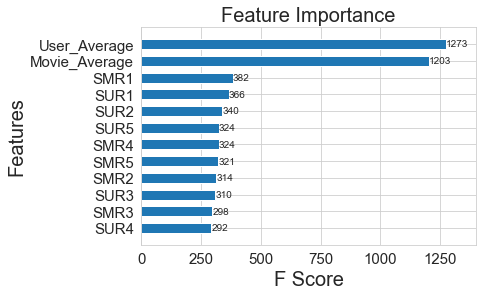

In [79]:
clf = xgb.XGBRegressor(n_estimators = 100, n_jobs=10, random_state=5)


train_result, test_result = train_test_xgboost(clf, x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

<a id='part82'></a>
#### 8.2 Surprise BaselineOnly Model

https://towardsdatascience.com/build-a-recommender-system-yelp-rating-prediction-example-collaborative-filtering-28a6e48a8cc



Let us start by introducing a simple baseline model. An assumption this model makes is that each user has some natural bias towards ratings he gives, and hence rate businesses higher or lower in general. The model also assumes the businesses each have a higher or lower propensity to appeal to people in general. Also, the data has some underlying bias, and hence, each source of bias is included to model ratings using the following equation:

**rᵤᵢ=μ + bᵤ +bᵢ**

If user u is unknown, then the bias bu is assumed to be zero. 

Here, μ is the average rating bias, and the parameters, bᵤ and bᵢ indicate the user and item bias respectively. For example, let us say that we want to find how a user ABC, might rate ‘SHAKE SHACK BURGERS’. Let us say that the average rating of all the restaurants in the data is 3.4, and in general, ‘SHAKE SHACK BURGERS’ is a highly rated restaurant, so it is rated 0.5 higher than the average. On the other hand, ‘ABC’ is a selective user and generally rates restaurants 0.4 lower than the average. So, the baseline estimate for the user ‘ABC’ for the restaurant ‘SHAKE SHACK BURGERS’ would be 3.4 + 0.5–0.4 = 3.5. The baseline function implemented estimates bᵤ and bᵢ to optimize following loss function (*):

**∑ (rᵤᵢ − (μ + bᵤ + bᵢ))² + λ (bᵤ² + bᵢ²) where rᵤᵢ ∈ R_train, λ is regularization**



Baselines can be estimated in two different ways:

- Using Stochastic Gradient Descent (SGD).
- Using Alternating Least Squares (ALS).

You can configure the way baselines are computed using the bsl_options parameter passed at the creation of an algorithm. This parameter is a dictionary for which the key 'method' indicates the method to use. Accepted values are 'als' (default) and 'sgd'. Depending on its value, other options may be set. For ALS:

    
**'reg_i':** The regularization parameter for items.  Default is 10.\
**'reg_u':** The regularization parameter for users. Default is 15.\
**'n_epochs':** The number of iteration of the ALS procedure. Default is 10.

And for SGD:
    
**'reg':** The regularization parameter of the cost function that is optimized,  Default is 0.02.\
**'learning_rate':** The learning rate of SGD,  Default is 0.005.\
**'n_epochs':** The number of iteration of the SGD procedure. Default is 20.

In [80]:
#You can check the docs of above used functions at:\
#https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

param_grid = {'bsl_options': {'method': ['sgd'],'learning_rate': [0.01, 0.03,0.1,0.3]}}

gs = GridSearchCV(BaselineOnly, param_grid=param_grid, measures=['rmse'], cv=3,joblib_verbose=0)

gs.fit(data)

train_result, test_result = surprise_model(gs.best_estimator["rmse"], trainset_data, testset_data, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
TRAIN DATA
RMSE = 0.8365845268760791
....................................................................................................
TEST DATA
RMSE = 1.0513476282402712
....................................................................................................
Time Taken = 0:00:01.112577


<a id='part83'></a>
#### 8.3 Surprise KNN-Baseline and KNBasic

https://towardsdatascience.com/how-to-build-a-memory-based-recommendation-system-using-python-surprise-55f3257b2cf4

When we work with kNN — type recommender algorithms, there are 2 hyperparameters we can tune: 

- k parameter (yes, same k as in the name of the model type)
- similarity option

The k parameter is fairly straightforward, and analogous to how it works in general k-nearest neighbours models: it is the upper limit of similar items we want the algorithm to consider. For example, if the user rated 20 games, but we set k to 10, when we estimate a rating to a new game, only those 10 games out of 20 that are the closest to the new game will be considered. You can also set min_k, if a user does not have enough ratings, the global average will be used for estimations. As a default, it’s 1.

We mentioned items being close to each other in the previous paragraph, but how do we determine that distance? It is the second hyperparameter, the similarity option, that defines the way to calculate it.

Let’s have a look at the sim_option configuration first. This parameter is a dictionary, with the following keys:

- **shrinkage:** won’t need for basic kNN models, only comes in play with the KNNBaseline model.
- **user_based:** Basically, there are two different routes when you want to estimate similarities. You can either compute how similar each item is to each other item, or do the same with the users. For my project, I used False, considering I had 100 items and 230k users.
- **min_support:** The minimum number of common points under which the similarity will be set to 0. Example: if min_support is 10, and there are two games, only 9 users rated them both, regardless of the ratings, the two games’ similarity will be 0. I did not experiment with this in my project, did not seem to be significant considering the scope of the data, so I used the default 1.
- **name:** The type of formula, to be discussed further below.

All the similarity functions will return a number between 0 and 1 to a specific (i, j) item pair. 1 means the ratings are perfectly aligned, 0 means there is no connection between the two items. In the formulas, rᵤᵢ is the rating user u gave to item i, μᵢ is the average ratings on item i, and Uᵢⱼ is the set of users that rated both items i and j. These are the three similarity metrics in the surprise similarity module:

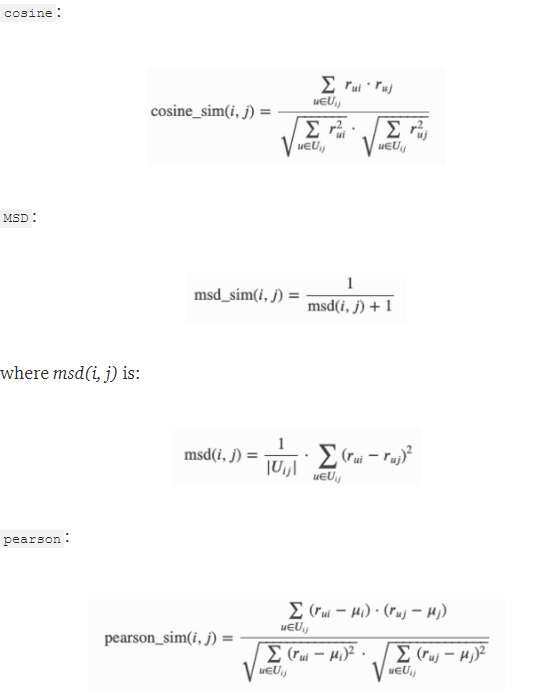



An example on how to define a sim_option parameter:
my_sim_option = {
    'name':'MSD', 'user_based':False, min_support = 1
    }
Now we did all the prep work, we can finally train some models.



#### KNN Models
There are three variations of basic KNN models in surprise. They define how rᵤᵢ , the rating user u would give to item i, is estimated in the predictions. The formulas below mostly use notations we have discussed in the previous section, a couple of new ones: σᵢ is the standard deviation of item i, Nᵤᵏ(i) is the maximum k items from the ones user u rated that are closest to item i.

Without further ado, the formulas:

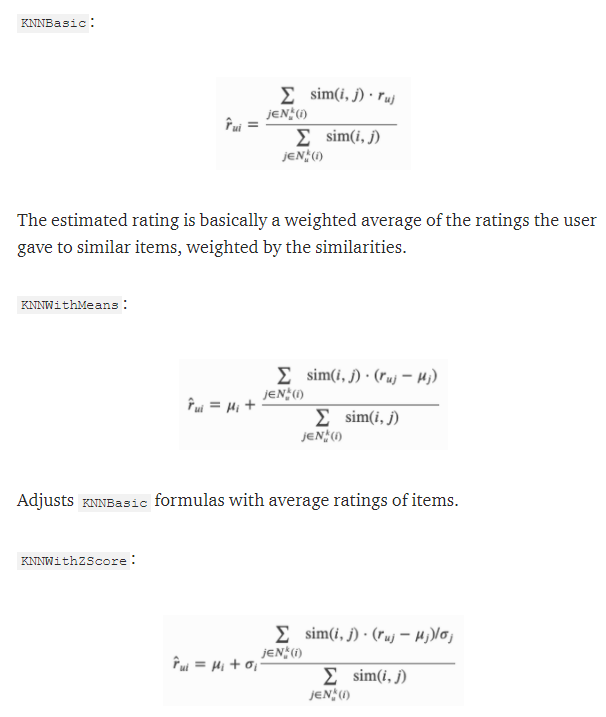

<a id='part84'></a>
#### 8.3.1 Surprise KNN-Baseline with User-User

In [81]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2,5], 
                              "shrinkage": [60,   140]}, 'k': [5, 20, 40],
              "bsl_options" : {"method":["sgd"], "learning_rate":[0.01,0.03,0.1], "n_epochs":[25,50]}}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3,joblib_verbose=0)
gs.fit(data)
algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = \
                   gs.best_params['rmse']["sim_options"], bsl_options=gs.best_params["rmse"]["bsl_options"])

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

<a id='part85'></a>
#### 8.3.2 Surprise KNN-Baseline with Movie-Movie

In [83]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2,5], 
                              "shrinkage": [60,   140]}, 'k': [5, 20, 40],
              "bsl_options" : {"method":["sgd"], "learning_rate":[0.01,0.03,0.1], "n_epochs":[25,50]}}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3,joblib_verbose=0)
gs.fit(data)
algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = gs.best_params['rmse']["sim_options"],\
                   bsl_options=gs.best_params["rmse"]["bsl_options"])

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "KNNBaseline_Movie")

model_train_evaluation["KNNBaseline_Movie"] = train_result
model_test_evaluation["KNNBaseline_Movie"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


<a id='part86'></a>
#### 8.3.3 Surprise KNNBasic with User-User

In [85]:
param_grid  = {'sim_options':{'name': ["cosine"], "user_based": [True], "min_support": [2,5], 
                              "shrinkage": [60,   140]}, 'k': [5, 20, 40],
              "bsl_options" : {"method":["sgd"], "learning_rate":[0.01,0.03,0.1], "n_epochs":[25,50]}}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3,joblib_verbose=0)

gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [86]:
algo = KNNBasic(k = gs.best_params['rmse']['k'], sim_options = gs.best_params['rmse']["sim_options"], bsl_options=gs.best_params["rmse"]["bsl_options"])

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "KNNBasic_User")

model_train_evaluation["KNNBasic_User"] = train_result
model_test_evaluation["KNNBasic_User"] = test_result

Computing the cosine similarity matrix...
Done computing similarity matrix.
TRAIN DATA
RMSE = 0.8314363604834564
....................................................................................................
TEST DATA
RMSE = 1.0737698142691254
....................................................................................................
Time Taken = 0:00:14.156479


<a id='part87'></a>
#### 8.3.4 Surprise KNNBasic with Movie-Movie

In [87]:
param_grid  = {'sim_options':{'name': ["cosine"], "user_based": [False], "min_support": [2,5], 
                              "shrinkage": [60,   140]}, 'k': [5, 20, 40],
              "bsl_options" : {"method":["sgd"], "learning_rate":[0.01,0.03,0.1], "n_epochs":[25,50]}}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3,joblib_verbose=0)

gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [88]:
algo = KNNBasic(k = gs.best_params['rmse']['k'], sim_options = gs.best_params['rmse']["sim_options"], bsl_options=gs.best_params["rmse"]["bsl_options"])

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "KNNBasic_Movie")

model_train_evaluation["KNNBasic_Movie"] = train_result
model_test_evaluation["KNNBasic_Movie"] = test_result

Computing the cosine similarity matrix...
Done computing similarity matrix.
TRAIN DATA
RMSE = 0.7742926887554423
....................................................................................................
TEST DATA
RMSE = 1.0762870753600888
....................................................................................................
Time Taken = 0:00:22.929587


<a id='part88'></a>
#### 8.4 Matrix Factorization SVD

References: 

http://rstudio-pubs-static.s3.amazonaws.com/335300_11d40bf12d8940f78d9661b3c63150dc.html \
https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/ \
https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65 \
http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/
 
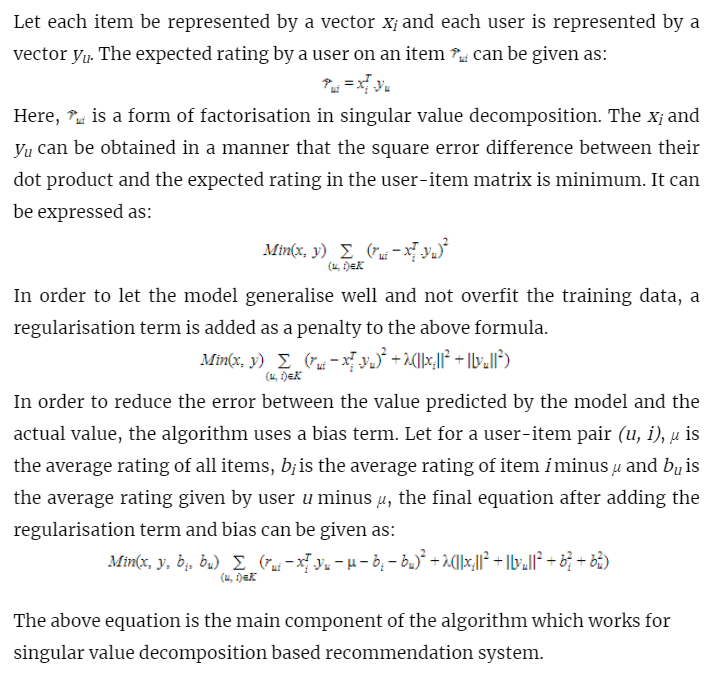

In [89]:
param_grid  = {'n_factors': [5,10,15,20,35,50,70,90]}  

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

#n_epochs – The number of iteration of the SGD procedure. Default is 20

algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)
train_result, test_result = surprise_model(algo, trainset_data, testset_data, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

## Summary


This section provides us with a snapshot of the RMSE scores for all the models we ran above on the train and the test datasets. 

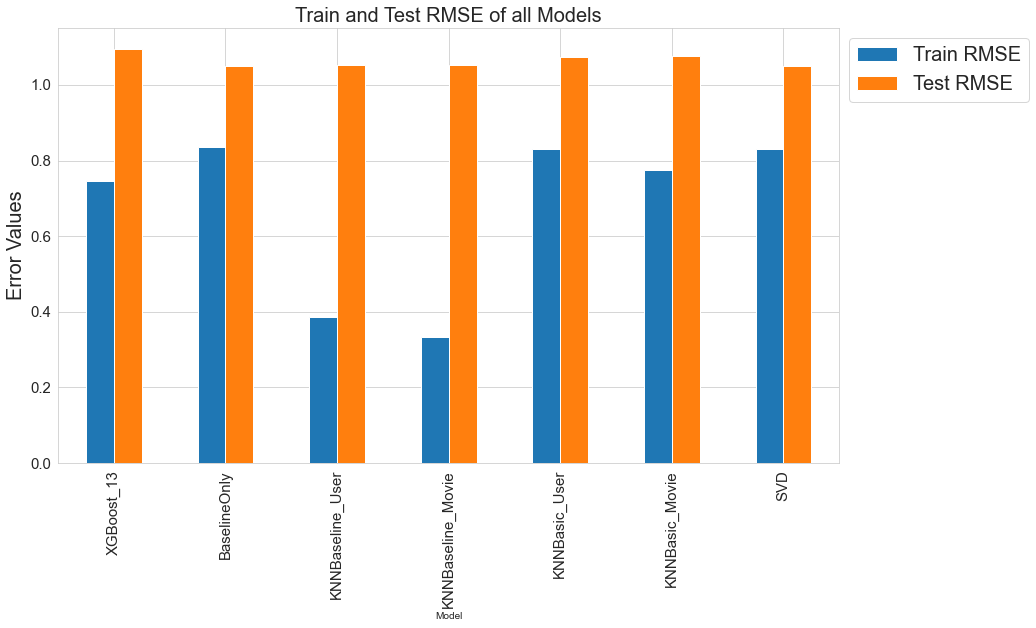

In [91]:
error_table[["Train RMSE","Test RMSE","Model"]].plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [92]:
error_table.style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.745798,1.095429
1,BaselineOnly,0.836585,1.051348
2,KNNBaseline_User,0.387269,1.051682
3,KNNBaseline_Movie,0.332116,1.051549
4,KNNBasic_User,0.831436,1.073770
5,KNNBasic_Movie,0.774293,1.076287
6,SVD,0.829440,1.049954


From above, we infer that the RMSE score for the SVD model is the least on the test dataset. 
On the train dataset, KNNBaseline_Movie has the least RMSE score. The difference between the RMSE scores on the train and the test datasets for the KNNBaseline_Movie suggests that it might be overfitting on the training set. 

# So, Here our Best Model is SVD with the least Test RMSE

<a id='part9'></a>
## 9. Recommendations

### Let us predict Movies for User 213 that they did not rate yet

Here is an example of where we have used SVD to predict movies for User213.

In [97]:
# The columns must correspond to user id, item id and ratings (in that order).
# Return a list of ratings that are not there in Trainset

recommend_data = trainset_data.build_anti_testset()

algo.fit(trainset_data)

user213_details = []
for i in range(len(recommend_data)):
    if recommend_data[i][0] ==213:
        user213_details.append(recommend_data[i])       

predictions = algo.test(user213_details)

user_predictions = []
for i in range(len(predictions)):
    user_predictions.append([user213_details[i][1], predictions[i].est])

In [137]:
sorted(user_predictions, key = lambda x: x[1],reverse=True)[:10]

[[2505, 3.97742845148695],
 [137, 3.913245161742776],
 [1849, 3.8908757377617937],
 [183, 3.8896390312111384],
 [150, 3.871136714437896],
 [138, 3.867084040873978],
 [1037, 3.8631534633897737],
 [1973, 3.850848179924695],
 [2516, 3.8420370459885236],
 [140, 3.841490100268472]]

### MovieID recommended to User 213 are 2505, 137, 1849, 183, 150, 138,1037,1973,2516 and 140

In [93]:
endtime = datetime.now()

endtime - starttime

datetime.timedelta(seconds=5726, microseconds=31225)

<a id='part10'></a>
## 10. Ethical Issues

In this section we'll discuss some of the ethical issues associated with recommender systems.

- Privacy: From the user point of view, privacy is a primary challenge for Recommender Systems. This may seem inevitable given most Recommender Systems use hybrid or Collaborative filtering techniques. Privacy concerns can arise at:
    - When data is collected
    - When data is stored
    - Privacy concerns can also arise at the stage of inferences that the system can draw from the data.


- Autonomy and personal identity: Recommender systems can encroach on individual user's autonomy by providing recommendation s that nudge users in a particular direction by attempting to "addict" them to certain types of content.


- Social effects: Recommender systems also tend to have a transformative impact on society. In particular, news recommender systems and social media filters, by the very nature of their design run the risk of insulating users from exposure to different viewpoints creating self enforcing biases and filter bubbles that are damaging to the normal functioning of public debate and democratic institutions generally.
